In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss

import warnings
warnings.simplefilter('ignore')
#赤背景になっている警告を非表示に

Survivedが0→死んでる　1→生きている

In [2]:
train_original = pd.read_csv("../input/titanic/train.csv")
test_original = pd.read_csv("../input/titanic/test.csv")
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv")
train = train_original
test = test_original
y_train = train["Survived"]

data_origin=pd.concat([train,test])
data_origin.index = np.arange(0,1309)

In [3]:
data = data_origin

data["Sex"] = data["Sex"].replace(["male","female"],[0,1])
data["Embarked"] = data["Embarked"].fillna("S")

data_em = pd.get_dummies(data[["Embarked"]],dtype=int)
data = data.join(data_em)
data = data.drop("Embarked",axis=1)

ticket_first =[]
for ticket_name in data["Ticket"]:
    ticket_first.append(ticket_name[0])
data["ticket_first"] = ticket_first
data_em = pd.get_dummies(data[["ticket_first"]],dtype=int)
data = data.join(data_em)
data = data.drop("ticket_first",axis=1)

data["Cabin"] =data["Cabin"].fillna("unknown")
data["Cabin"] = data["Cabin"].str[0]
data_em = pd.get_dummies(data[["Cabin"]],dtype=int)
data = data.join(data_em)
data = data.drop("Cabin",axis=1)

data["Age"] = data["Age"].fillna(data["Age"].median())
data["Fare"] = data["Fare"].fillna(data["Fare"].median())

data["familysize"] = data["Parch"]+data["SibSp"]+1
data["Alone"]=0
data.loc[data["familysize"]==1,"Alone"]=1

familylist = data["Name"].str.split(",").to_list()
#〇〇,Mr(Miss/Dr).△△.××：〇〇は姓、△△は名、××はミドルネームを表す
familymap = map(lambda x: x[0],familylist)
data["Family_name"] = list(familymap)

sex_list_origin = map(lambda x: x[1],familylist)
data["Sex2"] = list(sex_list_origin)
Sex2_list = data["Sex2"].str.split(".").to_list()
Sex2 = map(lambda x: x[0],Sex2_list)
data["Sex2"] = list(Sex2)
data["Family_name_size"] = data["Family_name"].str.cat(data["familysize"].astype(str))
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u,familysize,Alone,Family_name,Sex2,Family_name_size
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,1,2,0,Braund,Mr,Braund2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,2,0,Cumings,Mrs,Cumings2
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,1,1,1,Heikkinen,Miss,Heikkinen1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,...,0,0,0,0,0,2,0,Futrelle,Mrs,Futrelle2
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,...,0,0,0,0,1,1,1,Allen,Mr,Allen1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,28.0,0,0,A.5. 3236,8.0500,...,0,0,0,0,1,1,1,Spector,Mr,Spector1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,...,0,0,0,0,0,1,1,Oliva y Ocana,Dona,Oliva y Ocana1
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,...,0,0,0,0,1,1,1,Saether,Mr,Saether1
1307,1308,NaN,3,"Ware, Mr. Frederick",0,28.0,0,0,359309,8.0500,...,0,0,0,0,1,1,1,Ware,Mr,Ware1


In [4]:
data[["high-woman","center-woman","low-woman"]]=1
data["high-woman"] = data["high-woman"].where((data["Pclass"]==1) & (data["Sex"]==1),0)
data["center-woman"] = data["center-woman"].where((data["Pclass"]==2) & (data["Sex"]==1),0)
data["low-woman"] = data["low-woman"].where((data["Pclass"]==3) & (data["Sex"]==1),0)

data[["high-man","center-man","low-man"]]=1
data["high-man"] = data["high-man"].where((data["Pclass"]==1) & (data["Sex"]==0),0)
data["center-man"] = data["center-man"].where((data["Pclass"]==2) & (data["Sex"]==0),0)
data["low-man"] = data["low-man"].where((data["Pclass"]==3) & (data["Sex"]==0),0)

In [5]:
Ticket_Count = dict(data['Ticket'].value_counts())
data['TicketGroup'] = data['Ticket'].apply(lambda x:Ticket_Count[x]) # グループの振り分け
def Ticket_Label(s):
    if (s >= 2) & (s <= 4): # 文字数での生存率が高いグループ
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1): # 文字数での生存率が低いグループ
        return 1
    elif (s > 8):
        return 0

data['TicketGroup'] = data['TicketGroup'].apply(Ticket_Label)
data = data.drop("Ticket",axis=1)

In [6]:
data[["unknown-woman","unknown-man","unknown-high","unknown-middle","unknown-low","unknown-group0","unknown-group1","unknown-group2"]]=1

data["unknown-high"] = data["unknown-high"].where((data["Cabin_u"]==1) & (data["Pclass"]==3),0)
data["unknown-middle"] = data["unknown-middle"].where((data["Cabin_u"]==1) & (data["Pclass"]==2),0)
data["unknown-low"] = data["unknown-low"].where((data["Cabin_u"]==1) & (data["Pclass"]==1),0)
"""
data["unknown-group0"] = data["unknown-group0"].where((data["Cabin_u"]==1) & (data["TicketGroup"]==0),0)
data["unknown-group2"] = data["unknown-group2"].where((data["Cabin_u"]==1) & (data["TicketGroup"]==2),0)
data["unknown-group1"] = data["unknown-group1"].where((data["Cabin_u"]==1) & (data["TicketGroup"]==1),0)
"""

'\ndata["unknown-group0"] = data["unknown-group0"].where((data["Cabin_u"]==1) & (data["TicketGroup"]==0),0)\ndata["unknown-group2"] = data["unknown-group2"].where((data["Cabin_u"]==1) & (data["TicketGroup"]==2),0)\ndata["unknown-group1"] = data["unknown-group1"].where((data["Cabin_u"]==1) & (data["TicketGroup"]==1),0)\n'

In [7]:
# 苗字による特徴を調べる
Surname_Count = dict(data['Family_name'].value_counts()) # 苗字の個数を数える
data['Surname_Count'] = data['Family_name'].apply(lambda x:Surname_Count[x]) # 苗字の個数を代入

# 苗字にダブりがある人を、女・子供のグループと、大人で男性のグループに分ける
Female_Child_Group=data.loc[(data['Surname_Count']>=2) & ((data['Age']<=12) | (data['Sex']==1))]
Male_Adult_Group=data.loc[(data['Surname_Count']>=2) & (data['Age']>12) & (data['Sex']==0)]

# 女・子供グループにおける苗字ごとの生存率平均の個数を比較
Female_Child_mean = Female_Child_Group.groupby('Family_name')['Survived'].mean() # 苗字ごとの生存率平均
Female_Child_mean_count = pd.DataFrame(Female_Child_mean.value_counts()) # 苗字ごとの生存率平均の数
Female_Child_mean_count.columns=['GroupCount']

# 男（大人）グループにおける苗字ごとの生存率平均の個数を比較
Male_Adult_mean = Male_Adult_Group.groupby('Family_name')['Survived'].mean() # 苗字ごとの生存率平均
Male_Adult_mean_count = pd.DataFrame(Male_Adult_mean.value_counts()) # 苗字ごとの生存率平均の数
Male_Adult_mean_count.columns=['GroupCount']

Dead_List = set(Female_Child_mean[Female_Child_mean.apply(lambda x:x==0)].index)
print("Dead_List", Dead_List, sep="\n")
Survived_List = set(Male_Adult_mean[Male_Adult_mean.apply(lambda x:x==1)].index)
print("Survived_List", Survived_List, sep="\n")

train = data.loc[data['Survived'].notnull()]
test = data.loc[data['Survived'].isnull()]

# 女・子供グループで全員死亡した苗字の人→６０歳の男性、敬称はMrに。
# 男（大人）グループで全員生存した苗字の人→５才の女性、敬称はMissに。
test.loc[(test['Family_name'].apply(lambda x:x in Dead_List)),'Sex'] = 0
test.loc[(test['Family_name'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Family_name'].apply(lambda x:x in Dead_List)),'Sex2'] = 'Mr'
test.loc[(test['Family_name'].apply(lambda x:x in Survived_List)),'Sex'] = 1
test.loc[(test['Family_name'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Family_name'].apply(lambda x:x in Survived_List)),'Sex2'] = 'Miss'

# 再びデータを結合
data = pd.concat([train, test])
data = data.drop("Surname_Count",axis=1)

Dead_List
{'Turpin', 'Canavan', 'Johnston', 'Olsson', 'Rosblom', 'Vander Planke', 'Palsson', 'Van Impe', 'Ilmakangas', 'Attalah', 'Barbara', 'Sage', 'Lobb', 'Zabour', 'Oreskovic', 'Arnold-Franchi', 'Boulos', 'Lefebre', 'Rice', 'Goodwin', 'Bourke', 'Strom', 'Panula', 'Lahtinen', 'Caram', 'Cacic', 'Danbom', 'Skoog', 'Robins', 'Ford', 'Jussila'}
Survived_List
{'Duff Gordon', 'Dick', 'Harder', 'Beckwith', 'McCoy', 'Daly', 'Cardeza', 'Chambers', 'Goldenberg', 'Moubarek', 'Frolicher-Stehli', 'Frauenthal', 'Jonsson', 'Taylor', 'Kimball', 'Bradley', 'Bishop', 'Nakid', 'Greenfield', 'Jussila', 'Beane'}


In [8]:
"""
data["Family_name_size"] = data["Family_name"].str.cat(data["familysize"].astype(str))
fami_count = data.groupby("Family_name_size").count().iloc[:,0]
fami = (fami_count.loc[fami_count>1].index).to_list()
data["Family_name_size"] = data["Family_name_size"].where(data["Family_name_size"].isin(fami))

sex_count = data.groupby("Sex2").count().iloc[:,0]
sex2 = (sex_count.loc[sex_count>1].index).to_list()
data["Sex2"] = data["Sex2"].where(data["Sex2"].isin(sex2))
data
"""

'\ndata["Family_name_size"] = data["Family_name"].str.cat(data["familysize"].astype(str))\nfami_count = data.groupby("Family_name_size").count().iloc[:,0]\nfami = (fami_count.loc[fami_count>1].index).to_list()\ndata["Family_name_size"] = data["Family_name_size"].where(data["Family_name_size"].isin(fami))\n\nsex_count = data.groupby("Sex2").count().iloc[:,0]\nsex2 = (sex_count.loc[sex_count>1].index).to_list()\ndata["Sex2"] = data["Sex2"].where(data["Sex2"].isin(sex2))\ndata\n'

In [9]:
sc = StandardScaler()
sc.fit(data[["Age","Fare","familysize","Pclass"]])
data_std = sc.transform(data[["Age","Fare","familysize","Pclass"]])
data[["Age","Fare","familysize","Pclass"]] = pd.DataFrame(data_std)

dummy_fam = pd.get_dummies(data[["Family_name_size"]],dtype=int)
data = data.join(dummy_fam)
dummy_sex2 = pd.get_dummies(data[["Sex2"]],dtype=int)
data = data.join(dummy_sex2[["Sex2_ Mr","Sex2_ Mrs","Sex2_ Miss","Sex2_ Master"]])

drop_col = ["PassengerId","Name",'ticket_first_2',
        'ticket_first_4', 'ticket_first_6', 'ticket_first_7',
       'ticket_first_9', 'ticket_first_A', 'ticket_first_C', 'ticket_first_F',
       'ticket_first_L', 'ticket_first_S', 'ticket_first_W',"Sex2","Family_name","Family_name_size","familysize","Sex2"]

data = data.drop(drop_col,axis=1)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,...,Family_name_size_de Messemaeker2,Family_name_size_de Mulder1,Family_name_size_de Pelsmaeker1,Family_name_size_del Carlo2,Family_name_size_van Billiard3,Family_name_size_van Melkebeke1,Sex2_ Mr,Sex2_ Mrs,Sex2_ Miss,Sex2_ Master
0,0.0,0.841916,0,-0.586313,1,0,-0.503291,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,1.0,-1.546098,1,0.589926,1,0,0.734744,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,0.841916,1,-0.292254,0,0,-0.490240,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1.0,-1.546098,1,0.369381,1,0,0.383183,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.0,0.841916,0,0.369381,0,0,-0.487824,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,0.841916,0,-0.145224,0,0,-0.487824,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1305,NaN,-1.546098,1,0.663441,0,0,1.462034,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1306,NaN,0.841916,0,0.626683,0,0,-0.503291,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1307,NaN,0.841916,0,-0.145224,0,0,-0.487824,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [10]:
sur = data.corr()["Survived"].abs()
del_i = sur.loc[sur.sort_values()<0.02]
del_i = del_i.index
data = data.drop(del_i,axis=1)

In [11]:
x_train = data.loc[data["Survived"].notna()]
x_train = x_train.drop("Survived",axis=1)
x_test = data.loc[data["Survived"].isna()]
x_test = x_test.drop("Survived",axis=1)

In [12]:

#categorical featureなし

df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

x_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
#traintestsplitで2対8の割合で分割をする。

params = {'objective': 'binary',
          'metric': 'binary_logloss',
          'boosting': 'gbdt',
          'verbosity': -1,
          'random_state': 1}


lgb_train = lgb.Dataset(x_train_lgb,y_train_lgb)
lgb_valid = lgb.Dataset(x_valid_lgb,y_valid_lgb)

gbm=lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100),lgb.log_evaluation(period=100)])

y_prob = gbm.predict(x_valid_lgb)
y_pred = np.round(y_prob)
print(accuracy_score(y_valid_lgb, y_pred))

submit = gbm.predict(x_test)
submit = np.round(submit)

submit = submit.astype(int)
print(submit)
gender_submission["Survived"]=submit
df_submit = gender_submission
df_submit.to_csv("/kaggle/working/submission.csv",index=False)
#df_submit.to_csv("/kaggle/working/0516lgb.csv",index=False)

#0.79425：categorical featureなし（onehotあり） / optunaなし
#┗0.77033：名前の特徴量を追加。mr/missと家族の名前
#0.78974：categorical featureあり（onehotなし） / optunaなし
#0.77751：categorical featureなし（onehotあり） / optunaあり
#┗0.76794：名前の特徴量を追加。mr/missと家族の名前
#┗0.76794：名前+familysizeで家族の特徴量を追加
#┗0.78229：Surivivedとの相関が低い（0.02以下）の列を減らした。


Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.137892	valid's binary_logloss: 0.409503
Early stopping, best iteration is:
[41]	train's binary_logloss: 0.244301	valid's binary_logloss: 0.383733
0.8268156424581006
[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0

In [13]:

"""
train = train_original

train["Sex"] = train["Sex"].replace(["male","female"],[0,1])
train["Embarked"] = train["Embarked"].fillna("S")

train_em = pd.get_dummies(train[["Embarked"]],dtype=int)
train = train.join(train_em)
train = train.drop("Embarked",axis=1)

ticket_first =[]
for ticket_name in train["Ticket"]:
    ticket_first.append(ticket_name[0])
train["ticket_first"] = ticket_first
train_em = pd.get_dummies(train[["ticket_first"]],dtype=int)
train = train.join(train_em)
train = train.drop("ticket_first",axis=1)
train = train.drop("Ticket",axis=1)

train["Cabin"] =train["Cabin"].fillna("unknown")
train["Cabin"] = train["Cabin"].str[0]
train_em = pd.get_dummies(train[["Cabin"]],dtype=int)
train = train.join(train_em)
train = train.drop("Cabin",axis=1)

x_train = train
x_train["Age"] = x_train["Age"].fillna(x_train["Age"].median())

x_train["familysize"] = x_train["Parch"]+x_train["SibSp"]+1
x_train["Alone"]=0
x_train.loc[x_train["familysize"]==1,"Alone"]=1

sc = StandardScaler()
sc.fit(x_train[["Age","Fare","familysize","Pclass"]])
train_std = sc.transform(x_train[["Age","Fare","familysize","Pclass"]])
x_train[["Age","Fare","familysize","Pclass"]] = pd.DataFrame(train_std)

familylist = x_train["Name"].str.split(",").to_list()
#〇〇,Mr(Miss/Dr).△△.××：〇〇は姓、△△は名、××はミドルネームを表す
familymap = map(lambda x: x[0],familylist)
x_train["Family_name"] = list(familymap)

sex_list_origin = map(lambda x: x[1],familylist)
x_train["Sex2"] = list(sex_list_origin)
Sex2_list = x_train["Sex2"].str.split(".").to_list()
Sex2 = map(lambda x: x[0],Sex2_list)
x_train["Sex2"] = list(Sex2)

dummy_fam = pd.get_dummies(x_train[["Family_name"]],dtype=int)
x_train = x_train.join(dummy_fam)

dummy_sex2 = pd.get_dummies(x_train[["Sex2"]],dtype=int)
x_train = x_train.join(dummy_sex2)
"""

'\ntrain = train_original\n\ntrain["Sex"] = train["Sex"].replace(["male","female"],[0,1])\ntrain["Embarked"] = train["Embarked"].fillna("S")\n\ntrain_em = pd.get_dummies(train[["Embarked"]],dtype=int)\ntrain = train.join(train_em)\ntrain = train.drop("Embarked",axis=1)\n\nticket_first =[]\nfor ticket_name in train["Ticket"]:\n    ticket_first.append(ticket_name[0])\ntrain["ticket_first"] = ticket_first\ntrain_em = pd.get_dummies(train[["ticket_first"]],dtype=int)\ntrain = train.join(train_em)\ntrain = train.drop("ticket_first",axis=1)\ntrain = train.drop("Ticket",axis=1)\n\ntrain["Cabin"] =train["Cabin"].fillna("unknown")\ntrain["Cabin"] = train["Cabin"].str[0]\ntrain_em = pd.get_dummies(train[["Cabin"]],dtype=int)\ntrain = train.join(train_em)\ntrain = train.drop("Cabin",axis=1)\n\nx_train = train\nx_train["Age"] = x_train["Age"].fillna(x_train["Age"].median())\n\nx_train["familysize"] = x_train["Parch"]+x_train["SibSp"]+1\nx_train["Alone"]=0\nx_train.loc[x_train["familysize"]==1,"Alo

In [14]:
"""
test = test_original

test["Sex"] = test["Sex"].replace(["male","female"],[0,1])
test["Embarked"] = test["Embarked"].fillna("S")

test_em = pd.get_dummies(test[["Embarked"]],dtype=int)
test = test.join(test_em)
test = test.drop("Embarked",axis=1)

ticket_first =[]
for ticket_name in test["Ticket"]:
    ticket_first.append(ticket_name[0])
test["ticket_first"] = ticket_first
test_em = pd.get_dummies(test[["ticket_first"]],dtype=int)
test = test.join(test_em)
test = test.drop("ticket_first",axis=1)
test = test.drop("Ticket",axis=1)

test["Cabin"] =test["Cabin"].fillna("unknown")
test["Cabin"] = test["Cabin"].str[0]
test_em = pd.get_dummies(test[["Cabin"]],dtype=int)
test = test.join(test_em)
test = test.drop("Cabin",axis=1)

x_test = test
x_test["Age"] = x_test["Age"].fillna(x_test["Age"].mean())
x_test["Fare"] = x_test["Fare"].fillna(x_test["Fare"].median())

x_test["familysize"] = x_test["Parch"]+x_test["SibSp"]+1
x_test["Alone"]=0
x_test.loc[x_test["familysize"]==1,"Alone"]=1

sc.fit(x_test[["Age","Fare","familysize","Pclass"]])
test_std = sc.transform(x_test[["Age","Fare","familysize","Pclass"]])
x_test[["Age","Fare","familysize","Pclass"]] = pd.DataFrame(test_std)

familylist = x_test["Name"].str.split(",").to_list()
#〇〇,Mr(Miss/Dr).△△.××：〇〇は姓、△△は名、××はミドルネームを表す
familymap = map(lambda x: x[0],familylist)
x_test["Family_name"] = list(familymap)

sex_list_origin = map(lambda x: x[1],familylist)
x_test["Sex2"] = list(sex_list_origin)
Sex2_list = x_test["Sex2"].str.split(".").to_list()
Sex2 = map(lambda x: x[0],Sex2_list)
x_test["Sex2"] = list(Sex2)

dummy_fam = pd.get_dummies(x_test[["Family_name"]],dtype=int)
x_test = x_test.join(dummy_fam)
dummy_sex2 = pd.get_dummies(x_test[["Sex2"]],dtype=int)
x_test = x_test.join(dummy_sex2)
"""

'\ntest = test_original\n\ntest["Sex"] = test["Sex"].replace(["male","female"],[0,1])\ntest["Embarked"] = test["Embarked"].fillna("S")\n\ntest_em = pd.get_dummies(test[["Embarked"]],dtype=int)\ntest = test.join(test_em)\ntest = test.drop("Embarked",axis=1)\n\nticket_first =[]\nfor ticket_name in test["Ticket"]:\n    ticket_first.append(ticket_name[0])\ntest["ticket_first"] = ticket_first\ntest_em = pd.get_dummies(test[["ticket_first"]],dtype=int)\ntest = test.join(test_em)\ntest = test.drop("ticket_first",axis=1)\ntest = test.drop("Ticket",axis=1)\n\ntest["Cabin"] =test["Cabin"].fillna("unknown")\ntest["Cabin"] = test["Cabin"].str[0]\ntest_em = pd.get_dummies(test[["Cabin"]],dtype=int)\ntest = test.join(test_em)\ntest = test.drop("Cabin",axis=1)\n\nx_test = test\nx_test["Age"] = x_test["Age"].fillna(x_test["Age"].mean())\nx_test["Fare"] = x_test["Fare"].fillna(x_test["Fare"].median())\n\nx_test["familysize"] = x_test["Parch"]+x_test["SibSp"]+1\nx_test["Alone"]=0\nx_test.loc[x_test["fam

In [15]:
"""
x_tra = list(x_train.columns)
x_tes = list(x_test.columns)

tra_tes = [] # trainにはあるが、testにはない
tes_tra = [] # testにはあるが、trainにない

for i in x_tra:
    if i in x_tes:pass
    else:tra_tes.append(i)

for j in x_tes:
    if j in x_tra:pass
    else:tes_tra.append(j)
"""

'\nx_tra = list(x_train.columns)\nx_tes = list(x_test.columns)\n\ntra_tes = [] # trainにはあるが、testにはない\ntes_tra = [] # testにはあるが、trainにない\n\nfor i in x_tra:\n    if i in x_tes:pass\n    else:tra_tes.append(i)\n\nfor j in x_tes:\n    if j in x_tra:pass\n    else:tes_tra.append(j)\n'

In [16]:
"""
drop_col = ["PassengerId","Name",'ticket_first_2',
        'ticket_first_4', 'ticket_first_6', 'ticket_first_7',
       'ticket_first_9', 'ticket_first_A', 'ticket_first_C', 'ticket_first_F',
       'ticket_first_L', 'ticket_first_S', 'ticket_first_W',"Sex2","Family_name"]
x_test = x_test.drop(drop_col,axis=1)
x_test = x_test.drop(tes_tra,axis=1)
x_test
"""

'\ndrop_col = ["PassengerId","Name",\'ticket_first_2\',\n        \'ticket_first_4\', \'ticket_first_6\', \'ticket_first_7\',\n       \'ticket_first_9\', \'ticket_first_A\', \'ticket_first_C\', \'ticket_first_F\',\n       \'ticket_first_L\', \'ticket_first_S\', \'ticket_first_W\',"Sex2","Family_name"]\nx_test = x_test.drop(drop_col,axis=1)\nx_test = x_test.drop(tes_tra,axis=1)\nx_test\n'

In [17]:
"""
drop_col = ["PassengerId","Name", 'ticket_first_2',
        'ticket_first_4', 'ticket_first_6', 'ticket_first_7',
       'ticket_first_9', 'ticket_first_A', 'ticket_first_C', 'ticket_first_F',
       'ticket_first_L', 'ticket_first_S', 'ticket_first_W',"Sex2","Family_name"]
x_train = x_train.drop(drop_col,axis=1)
x_train = x_train.drop(tra_tes,axis=1)
x_train
"""

'\ndrop_col = ["PassengerId","Name", \'ticket_first_2\',\n        \'ticket_first_4\', \'ticket_first_6\', \'ticket_first_7\',\n       \'ticket_first_9\', \'ticket_first_A\', \'ticket_first_C\', \'ticket_first_F\',\n       \'ticket_first_L\', \'ticket_first_S\', \'ticket_first_W\',"Sex2","Family_name"]\nx_train = x_train.drop(drop_col,axis=1)\nx_train = x_train.drop(tra_tes,axis=1)\nx_train\n'

In [18]:
#K近傍法：求めたい点の周辺の何個かの点を取る。その点が0か1のどちらかを特定する。0か1のどちらが多いか多数決で決めるモデル
"""

df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

knn = KNeighborsClassifier()
#K-nnの手法。これは求めたい値から周辺にいくつかの点をリストアップする。その周辺にある点が0か1のどちらかを推定し、多い方を利用する
param_test = {'n_neighbors':list(range(1, 10, 1))} 
#n_neighborsは周辺の何個の点を取得するかを表したもの。今回は1~50個のうち、どれが適切かをgridsearchで特定している
grid = GridSearchCV(estimator = knn, param_grid = param_test, scoring='accuracy', cv=10)
grid.fit(x_train, y_train)
print(grid.best_params_, grid.best_score_, sep="\n")

submit = grid.predict(x_test)
PassengerId = pd.DataFrame(test["PassengerId"])
print(submit)

df_submit = pd.DataFrame(submit)
df_submit = PassengerId.join(df_submit)
df_submit.columns =["PassengerId","Survived"]
#df_submit.to_csv("/kaggle/working/submission.csv",index=False)
df_submit.to_csv("/kaggle/working/0504knn.csv",index=False)

#0.73205：ticketなし
#（0.79578）：ticketあり。1,3,Pのみ
"""

'\n\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nknn = KNeighborsClassifier()\n#K-nnの手法。これは求めたい値から周辺にいくつかの点をリストアップする。その周辺にある点が0か1のどちらかを推定し、多い方を利用する\nparam_test = {\'n_neighbors\':list(range(1, 10, 1))} \n#n_neighborsは周辺の何個の点を取得するかを表したもの。今回は1~50個のうち、どれが適切かをgridsearchで特定している\ngrid = GridSearchCV(estimator = knn, param_grid = param_test, scoring=\'accuracy\', cv=10)\ngrid.fit(x_train, y_train)\nprint(grid.best_params_, grid.best_score_, sep="\n")\n\nsubmit = grid.predict(x_test)\nPassengerId = pd.DataFrame(test["PassengerId"])\nprint(submit)\n\ndf_submit = pd.DataFrame(submit)\ndf_submit = PassengerId.join(df_submit)\ndf_submit.columns =["PassengerId","Survived"]\n#df_submit.to_csv("/kaggle/working/submission.csv",index=False)\ndf_submit.to_csv("/kaggle/working/0504knn.csv",index=False)\n\n#0.73205：ticketなし\n#（0.79578）：ticketあり。1,3,Pのみ\n'

In [19]:
"""
#ランダムフォレスト：決定木を複数作成をして、どちらに該当するかモデルを作ること。
#決定木と異なるのは、複数のサンプルをリストアップしてその複数の決定木を作り、その平均/多数決で決めること


df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

rfc = RandomForestClassifier(random_state = 100, max_features='sqrt')
param_test = {'n_estimators':list(range(20, 30, 1)), #20～30を１刻みずつ試す
              'max_depth':list(range(3, 10, 1))} #3～10を１刻みずつ試す
grid = GridSearchCV(estimator = rfc, param_grid = param_test, scoring='accuracy', cv=10)
grid.fit(x_train, y_train)
print(grid.best_params_, grid.best_score_, sep="\n")

submit = grid.predict(x_test)
PassengerId = pd.DataFrame(test["PassengerId"])
print(submit)

gender_submission["Survived"] = submit
df_submit = gender_submission
#df_submit.to_csv("/kaggle/working/submission.csv",index=False)
df_submit.to_csv("/kaggle/working/0516rand.csv",index=False)

#0.77033：ticketなし
#0.76794（0.829）:ticketの特徴量あり 
#0.77751（0.83059）：ticket特徴量あり。1,3,Pのみ
#0.78229：ticketの特徴量あり。名前+familysizeの特徴量がある
"""

'\n#ランダムフォレスト：決定木を複数作成をして、どちらに該当するかモデルを作ること。\n#決定木と異なるのは、複数のサンプルをリストアップしてその複数の決定木を作り、その平均/多数決で決めること\n\n\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nrfc = RandomForestClassifier(random_state = 100, max_features=\'sqrt\')\nparam_test = {\'n_estimators\':list(range(20, 30, 1)), #20～30を１刻みずつ試す\n              \'max_depth\':list(range(3, 10, 1))} #3～10を１刻みずつ試す\ngrid = GridSearchCV(estimator = rfc, param_grid = param_test, scoring=\'accuracy\', cv=10)\ngrid.fit(x_train, y_train)\nprint(grid.best_params_, grid.best_score_, sep="\n")\n\nsubmit = grid.predict(x_test)\nPassengerId = pd.DataFrame(test["PassengerId"])\nprint(submit)\n\ngender_submission["Survived"] = submit\ndf_submit = gender_submission\n#df_submit.to_csv("/kaggle/working/submission.csv",index=False)\ndf_submit.to_csv("/kaggle/working/0516rand.csv",index=False)\n\n#0.77033：ticketなし\n#0.76794（0.829）:ticketの特徴量あり \n#0.77751（0.83059）：ticket特徴量あり。1,3,Pのみ\n#0.78229：ticketの特徴量あり。名前+fami

clf
ランダムフォレストを利用。ランダムフォレストとは、あるデータセットをいくつかに分けて、それぞれで決定木を作成していく。その作成したモデルを使い、数値を特定。その後は多数決で決める。
random_stateは決定木の数のこと。増やせば、分類の精度が上がる。max_featuersは利用する特徴量の数のこと。多いと1つのデータの精度は上がるが、似たようなデータになる。基本は全特徴量の平方根、つまりsqrt。

pipe
パイプラインでモデルを作成できる。パイプラインとは、モデルを連続で反映させたいときに順番を指定して反映できる。これによりコードを書く量が圧倒的に減る。
https://qiita.com/c60evaporator/items/7829d8d8322a407d54f1#:~:text=%E8%A7%A3%E8%AA%AC%E3%81%97%E3%81%BE%E3%81%99-,%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%A8%E5%89%8D%E5%87%A6%E7%90%86,%E3%81%82%E3%82%8B%E3%81%93%E3%81%A8%E3%81%8C%E5%A4%9A%E3%81%84%E3%81%A7%E3%81%99%E3%80%82&text=%E3%81%93%E3%81%AE%E4%B8%80%E9%80%A3%E3%81%AE%E5%87%A6%E7%90%86%E3%82%92,%E3%83%91%E3%82%A4%E3%83%97%E3%83%A9%E3%82%A4%E3%83%B3%E3%81%A8%E5%91%BC%E3%81%B3%E3%81%BE%E3%81%99%E3%80%82

param_test
パラメーターを指定するもの。n_estimatorsはその決定木の数のこと。max_depthは決定木を下になんこつなげるかを表したもの。今回はリストで複数のパラメーターを試せるようにしている
https://tatsu-mk2.hatenablog.jp/entry/2019/05/04/185733

grid
グリッドサーチ。様々あるパラメーターのなかでどの組み合わせがもっとも効果が高いか推定するためのライブラリ。estimatorが適応するモデル。param gridはパラメーターのリスト。scoringは効果測定の方法。今回のaccuracyは正答率。その他にもF値など。cvはクロスバリデーションの数。
https://di-acc2.com/programming/python/8465/

クロスバリデーション
練習データを1回だけ使ってしまうと、過学習になる可能性がある。そこで、練習データを何等分かして、練習データとテストデータに分けてモデルを作成。そこで作ったモデルをいくつか組み合わせて平均値を取る方法。cv=10であるため、10こにデータを分けている
https://qiita.com/Takayoshi_Makabe/items/d35eed0c3064b495a08b


In [20]:
#ロジスティック回帰：複数の特徴量をもとにしたグラフを作成し、そのグラフの間に線を引く。そのどちらに所属しているかを0と1で判断。それをモデル化して判定している

"""
df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

lre = LogisticRegression()
param_test = {'C':[0.001,0.01,0.1,1,10,100,1000]}
#Cとは、「コストパラメーター」の略であり、誤分類を許容する指標のこと。Cが大きいと誤分類を許容しない（外れ値をいれて評価）ため、学習されやすくなる。Cが小さすぎると誤分類を許容する（外れ値をいれずに評価）ため、学習が進みにくい。基本は1である

grid = GridSearchCV(estimator = lre, param_grid = param_test, scoring='accuracy', cv=10)
grid.fit(x_train, y_train)
print(grid.best_params_, grid.best_score_, sep="\n")

submit = grid.predict(x_test)
print(submit)

gender_submission["Survived"] = submit
df_submit = gender_submission
#df_submit.to_csv("/kaggle/working/submission.csv",index=False)
df_submit.to_csv("/kaggle/working/0516lre.csv",index=False)

#0.77033：ticketなし
#（0.80474）：ticketあり。1,3,Pのみ
"""

'\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nlre = LogisticRegression()\nparam_test = {\'C\':[0.001,0.01,0.1,1,10,100,1000]}\n#Cとは、「コストパラメーター」の略であり、誤分類を許容する指標のこと。Cが大きいと誤分類を許容しない（外れ値をいれて評価）ため、学習されやすくなる。Cが小さすぎると誤分類を許容する（外れ値をいれずに評価）ため、学習が進みにくい。基本は1である\n\ngrid = GridSearchCV(estimator = lre, param_grid = param_test, scoring=\'accuracy\', cv=10)\ngrid.fit(x_train, y_train)\nprint(grid.best_params_, grid.best_score_, sep="\n")\n\nsubmit = grid.predict(x_test)\nprint(submit)\n\ngender_submission["Survived"] = submit\ndf_submit = gender_submission\n#df_submit.to_csv("/kaggle/working/submission.csv",index=False)\ndf_submit.to_csv("/kaggle/working/0516lre.csv",index=False)\n\n#0.77033：ticketなし\n#（0.80474）：ticketあり。1,3,Pのみ\n'

In [21]:
#サポートベクターマシーン（SVM）：カテゴリを分ける特徴量を軸として境界線を作成。その2つの部分でtestのデータがどちらに入っているかを判定するモデル。
"""
df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

svm = SVC()
param_test = {'C':[0.001,0.01,0.1,1,10,100,1000],"gamma":[100,10,1,0.1,0.01,0.001]}
#Cとは、「コストパラメーター」の略であり、誤分類を許容する指標のこと。Cが大きいと誤分類を許容しない（外れ値をいれて評価）ため、学習されやすくなる。Cが小さすぎると誤分類を許容する（外れ値をいれずに評価）ため、学習が進みにくい。基本は1である
#gammaとは境界線の形を表す指標。この値が大きいほど曲がった線が多くなるなど、複雑な境界になる。一方で小さい場合には直線が多くなる。つまりgammaが大きいと過学習されやすくて、小さい場合は学習されにくい

grid = GridSearchCV(estimator = svm, param_grid = param_test, scoring='accuracy', cv=10)
grid.fit(x_train, y_train)
print(grid.best_params_, grid.best_score_, sep="\n")

submit = grid.predict(x_test)
PassengerId = pd.DataFrame(test["PassengerId"])
print(submit)

df_submit = pd.DataFrame(submit)
df_submit = PassengerId.join(df_submit)
df_submit.columns =["PassengerId","Survived"]
#df_submit.to_csv("/kaggle/working/submission.csv",index=False)
df_submit.to_csv("/kaggle/working/0504svm.csv",index=False)

#0.76555：ticketなし
#0.76315（0.83617）：ticket特徴量あり
#0.76794（0.82837）：ticket特徴量あり。1,3,Pのみ
"""

'\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nsvm = SVC()\nparam_test = {\'C\':[0.001,0.01,0.1,1,10,100,1000],"gamma":[100,10,1,0.1,0.01,0.001]}\n#Cとは、「コストパラメーター」の略であり、誤分類を許容する指標のこと。Cが大きいと誤分類を許容しない（外れ値をいれて評価）ため、学習されやすくなる。Cが小さすぎると誤分類を許容する（外れ値をいれずに評価）ため、学習が進みにくい。基本は1である\n#gammaとは境界線の形を表す指標。この値が大きいほど曲がった線が多くなるなど、複雑な境界になる。一方で小さい場合には直線が多くなる。つまりgammaが大きいと過学習されやすくて、小さい場合は学習されにくい\n\ngrid = GridSearchCV(estimator = svm, param_grid = param_test, scoring=\'accuracy\', cv=10)\ngrid.fit(x_train, y_train)\nprint(grid.best_params_, grid.best_score_, sep="\n")\n\nsubmit = grid.predict(x_test)\nPassengerId = pd.DataFrame(test["PassengerId"])\nprint(submit)\n\ndf_submit = pd.DataFrame(submit)\ndf_submit = PassengerId.join(df_submit)\ndf_submit.columns =["PassengerId","Survived"]\n#df_submit.to_csv("/kaggle/working/submission.csv",index=False)\ndf_submit.to_csv("/kaggle/working/0504svm.csv",index=False)\n\n#0.76555：ticketなし\n#0.76315（0.83617）：ticket特徴量あり

In [22]:
"""
train_original = pd.read_csv("../input/titanic/train.csv")
test_original = pd.read_csv("../input/titanic/test.csv")
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv")
train = train_original
test = test_original
y_train = train["Survived"]
"""

'\ntrain_original = pd.read_csv("../input/titanic/train.csv")\ntest_original = pd.read_csv("../input/titanic/test.csv")\ngender_submission = pd.read_csv("../input/titanic/gender_submission.csv")\ntrain = train_original\ntest = test_original\ny_train = train["Survived"]\n'

In [23]:
"""
train = train_original

train["Sex"] = train["Sex"].replace(["male","female"],[0,1])
train["Embarked"] = train["Embarked"].fillna("S")
train["Embarked"] = train["Embarked"].replace(["C","Q","S"],[0,1,2])

ticket_first =[]
for ticket_name in train["Ticket"]:
    ticket_first.append(ticket_name[0])
train["ticket_first"] = ticket_first
ti_list = train["ticket_first"].unique().tolist()
train["ticket_first"] = train["ticket_first"].replace(ti_list,np.arange(len(ti_list)).tolist())
train = train.drop("Ticket",axis=1)

train["Cabin"] =train["Cabin"].fillna("unknown")
train["Cabin"] = train["Cabin"].str[0]

train["Cabin"] = train["Cabin"].replace(train["Cabin"].unique().tolist(),np.arange(9).tolist())

x_train = train
x_train["Age"] = x_train["Age"].fillna(x_train["Age"].median())

x_train["familysize"] = x_train["Parch"]+x_train["SibSp"]+1
x_train["Alone"]=0
x_train.loc[x_train["familysize"]==1,"Alone"]=1

sc = StandardScaler()
sc.fit(x_train[["Age","Fare","familysize"]])
train_std = sc.transform(x_train[["Age","Fare","familysize"]])
x_train[["Age","Fare","familysize"]] = pd.DataFrame(train_std)

familylist = x_train["Name"].str.split(",").to_list()
#〇〇,Mr(Miss/Dr).△△.××：〇〇は姓、△△は名、××はミドルネームを表す
familymap = map(lambda x: x[0],familylist)
x_train["Family_name"] = list(familymap)

sex_list_origin = map(lambda x: x[1],familylist)
x_train["Sex2"] = list(sex_list_origin)
Sex2_list = x_train["Sex2"].str.split(".").to_list()
Sex2 = map(lambda x: x[0],Sex2_list)
x_train["Sex2"] = list(Sex2)

drop_col = ["PassengerId","Survived","Name"]
x_train = x_train.drop(drop_col,axis=1)
x_train
"""

'\ntrain = train_original\n\ntrain["Sex"] = train["Sex"].replace(["male","female"],[0,1])\ntrain["Embarked"] = train["Embarked"].fillna("S")\ntrain["Embarked"] = train["Embarked"].replace(["C","Q","S"],[0,1,2])\n\nticket_first =[]\nfor ticket_name in train["Ticket"]:\n    ticket_first.append(ticket_name[0])\ntrain["ticket_first"] = ticket_first\nti_list = train["ticket_first"].unique().tolist()\ntrain["ticket_first"] = train["ticket_first"].replace(ti_list,np.arange(len(ti_list)).tolist())\ntrain = train.drop("Ticket",axis=1)\n\ntrain["Cabin"] =train["Cabin"].fillna("unknown")\ntrain["Cabin"] = train["Cabin"].str[0]\n\ntrain["Cabin"] = train["Cabin"].replace(train["Cabin"].unique().tolist(),np.arange(9).tolist())\n\nx_train = train\nx_train["Age"] = x_train["Age"].fillna(x_train["Age"].median())\n\nx_train["familysize"] = x_train["Parch"]+x_train["SibSp"]+1\nx_train["Alone"]=0\nx_train.loc[x_train["familysize"]==1,"Alone"]=1\n\nsc = StandardScaler()\nsc.fit(x_train[["Age","Fare","famil

In [24]:
"""
test = test_original

test["Sex"] = test["Sex"].replace(["male","female"],[0,1])
test["Embarked"] = test["Embarked"].fillna("S")
test["Embarked"] = test["Embarked"].replace(["C","Q","S"],[0,1,2])

ticket_first =[]
for ticket_name in test["Ticket"]:
    ticket_first.append(ticket_name[0])
test["ticket_first"] = ticket_first
ti_list = test["ticket_first"].unique().tolist()
test["ticket_first"] = test["ticket_first"].replace(ti_list,np.arange(len(ti_list)).tolist())
test = test.drop("Ticket",axis=1)

test["Cabin"] =test["Cabin"].fillna("unknown")
test["Cabin"] = test["Cabin"].str[0]
cabin_list = test["Cabin"].unique().tolist()
test["Cabin"] = test["Cabin"].replace(cabin_list,np.arange(len(cabin_list)).tolist())

x_test = test
x_test["Age"] = x_test["Age"].fillna(x_test["Age"].median())

x_test["familysize"] = x_test["Parch"]+x_test["SibSp"]+1
x_test["Alone"]=0
x_test.loc[x_test["familysize"]==1,"Alone"]=1

sc = StandardScaler()
sc.fit(x_test[["Age","Fare","familysize"]])
test_std = sc.transform(x_test[["Age","Fare","familysize"]])
x_test[["Age","Fare","familysize"]] = pd.DataFrame(test_std)

familylist = x_test["Name"].str.split(",").to_list()
#〇〇,Mr(Miss/Dr).△△.××：〇〇は姓、△△は名、××はミドルネームを表す
familymap = map(lambda x: x[0],familylist)
x_test["Family_name"] = list(familymap)

sex_list_origin = map(lambda x: x[1],familylist)
x_test["Sex2"] = list(sex_list_origin)
Sex2_list = x_test["Sex2"].str.split(".").to_list()
Sex2 = map(lambda x: x[0],Sex2_list)
x_test["Sex2"] = list(Sex2)

drop_col = ["PassengerId","Name"]
x_test = x_test.drop(drop_col,axis=1)
x_test
"""

'\ntest = test_original\n\ntest["Sex"] = test["Sex"].replace(["male","female"],[0,1])\ntest["Embarked"] = test["Embarked"].fillna("S")\ntest["Embarked"] = test["Embarked"].replace(["C","Q","S"],[0,1,2])\n\nticket_first =[]\nfor ticket_name in test["Ticket"]:\n    ticket_first.append(ticket_name[0])\ntest["ticket_first"] = ticket_first\nti_list = test["ticket_first"].unique().tolist()\ntest["ticket_first"] = test["ticket_first"].replace(ti_list,np.arange(len(ti_list)).tolist())\ntest = test.drop("Ticket",axis=1)\n\ntest["Cabin"] =test["Cabin"].fillna("unknown")\ntest["Cabin"] = test["Cabin"].str[0]\ncabin_list = test["Cabin"].unique().tolist()\ntest["Cabin"] = test["Cabin"].replace(cabin_list,np.arange(len(cabin_list)).tolist())\n\nx_test = test\nx_test["Age"] = x_test["Age"].fillna(x_test["Age"].median())\n\nx_test["familysize"] = x_test["Parch"]+x_test["SibSp"]+1\nx_test["Alone"]=0\nx_test.loc[x_test["familysize"]==1,"Alone"]=1\n\nsc = StandardScaler()\nsc.fit(x_test[["Age","Fare","fa

In [25]:
"""
#categorical featureあり

df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

x_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
#traintestsplitで2対8の割合で分割をする。

categorical_features=["Cabin","ticket_first"]
#よくわからないが、gmbを使うときにはdatasetを分けて作成する必要がある

params = {'objective': 'binary',
          'metric': 'binary_logloss',
          'boosting': 'gbdt',
          'verbosity': -1,
          'random_state': 0}


lgb_train = lgb.Dataset(x_train_lgb,y_train_lgb,categorical_feature=categorical_features)
lgb_valid = lgb.Dataset(x_valid_lgb,y_valid_lgb,categorical_feature=categorical_features)

gbm=lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100),lgb.log_evaluation(period=100)])

y_prob = gbm.predict(x_valid_lgb)
y_pred = np.round(y_prob)
print(accuracy_score(y_valid_lgb, y_pred))

submit = gbm.predict(x_test)
submit = np.round(submit)

submit = submit.astype(int)
gender_submission["Survived"]=submit
df_submit = gender_submission
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

#0.79425：categorical featureなし（onehotあり） / optunaなし
#0.78974：categorical featureあり（onehotなし） / optunaなし
#0.77751：categorical featureなし（onehotあり） / optunaあり
"""

'\n#categorical featureあり\n\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nx_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=42)\n#traintestsplitで2対8の割合で分割をする。\n\ncategorical_features=["Cabin","ticket_first"]\n#よくわからないが、gmbを使うときにはdatasetを分けて作成する必要がある\n\nparams = {\'objective\': \'binary\',\n          \'metric\': \'binary_logloss\',\n          \'boosting\': \'gbdt\',\n          \'verbosity\': -1,\n          \'random_state\': 0}\n\n\nlgb_train = lgb.Dataset(x_train_lgb,y_train_lgb,categorical_feature=categorical_features)\nlgb_valid = lgb.Dataset(x_valid_lgb,y_valid_lgb,categorical_feature=categorical_features)\n\ngbm=lgb.train(\n    params,\n    lgb_train,\n    valid_sets=[lgb_train, lgb_valid],\n    valid_names=[\'train\', \'valid\'],\n    num_boost_round=1000,\n    callbacks=[lgb.early_stopping(100),lgb.log_evaluation(period=100)])\n\ny_prob = gbm.predict(x_valid_lgb)\ny_p

x_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=42)<br>
練習データをtrainとvalidに分けて、LightGBMが使えるように加工している。

def objective(trial):

    params = {
        'objective': 'binary',
        #objectiveとは、「目的」の意味。今回のモデルを作成する意味は二項分類であるため、binaryを選択。他に回帰であればregressionになる
        'metric': 'binary_logloss',
        #metricはモデル構築の損失関数の指定。binaryの場合はbinaryloglossかaucでregressionの場合はrmseやmaeなどがある。
        'boosting': 'gbdt',
        #モデル選択。gbdt,rf,dart,gossの4種類ある
        'max_depth':trial.suggest_int('max_depth', 1, 10),
        #モデルの深さの最大値を設定。モデルの深さを設定することで、過学習になりにくくなる
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 1, 80),
        #モデルの葉の最小データ数を指定。
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        #学習率。前のモデルをどれくらい更新するかをしていする。
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        #lambdaとは正則化の意味。正則化とは、データが複雑になるほどペナルティを与えるもの
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        # 1つのモデルあたりの葉の数のこと。
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        #特徴量の何％を使うか指定する。
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        #バギングの際に訓練データの何％を使うか指定する。
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
         #バギングを行う頻度を指定する。
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbosity': -1,
        #学習途中の情報を表示するか否か
        'random_state': 0,
    }


    lgb_train = lgb.Dataset(x_train_lgb,y_train_lgb)
    lgb_valid = lgb.Dataset(x_valid_lgb,y_valid_lgb)

    gbm=lgb.train(
        params,
        #パラメーター
        lgb_train,
        #トレーニングデータ
        valid_sets=[lgb_train, lgb_valid],
        valid_names=['train', 'valid'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(100),lgb.log_evaluation(period=100)])
        #early_stoppingは、指定した回数の学習を進めても改善が見られない場合には学習を打ち切るもの。
        #log_evaluationを入れることで、それぞれのイテレーション時に評価指標を出力してくれる
        #callbackについてはこちらが詳しい
        https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
        https://datawokagaku.com/lightgbm/

    y_prob = gbm.predict(x_valid_lgb)
    y_pred = np.round(y_prob)
    return(accuracy_score(y_valid_lgb, y_pred))

study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

y_pred =gbm.predict(x_valid_lgb,num_iteration=gbm.best_iteration,predict_disable_shape_check=True)
y_pred = (y_pred>0.5).astype(int)
accuracy_score(y_valid_lgb, y_pred)

In [26]:
"""
#categorical featureなし / optunaあり

df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

x_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

def objective(trial):

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'max_depth':trial.suggest_int('max_depth', 1, 10),
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 1, 80),
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbosity': -1,
        'random_state': 0,
    }


    lgb_train = lgb.Dataset(x_train_lgb,y_train_lgb)
    lgb_valid = lgb.Dataset(x_valid_lgb,y_valid_lgb)

    gbm=lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=['train', 'valid'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(100),lgb.log_evaluation(period=100)])
    
    y_prob = gbm.predict(x_valid_lgb)
    y_pred = np.round(y_prob)
    return accuracy_score(y_valid_lgb, y_pred)

study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)
study.best_params
"""

'\n#categorical featureなし / optunaあり\n\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nx_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=42)\n\ndef objective(trial):\n\n    params = {\n        \'objective\': \'binary\',\n        \'metric\': \'binary_logloss\',\n        \'boosting\': \'gbdt\',\n        \'max_depth\':trial.suggest_int(\'max_depth\', 1, 10),\n        \'min_data_in_leaf\':trial.suggest_int(\'min_data_in_leaf\', 1, 80),\n        \'learning_rate\':trial.suggest_loguniform(\'learning_rate\', 0.001, 0.1),\n        \'lambda_l1\': trial.suggest_loguniform(\'lambda_l1\', 1e-8, 10.0),\n        \'lambda_l2\': trial.suggest_loguniform(\'lambda_l2\', 1e-8, 10.0),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 2, 512),\n        \'feature_fraction\': trial.suggest_uniform(\'feature_fraction\', 0.4, 1.0),\n        \'bagging_fraction\': trial.suggest_uniform(\'bagg

In [27]:
"""
df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

x_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'max_depth':study.best_params["max_depth"],
    'min_data_in_leaf':study.best_params["min_data_in_leaf"],
    'learning_rate':study.best_params["learning_rate"],
    'lambda_l1': study.best_params["lambda_l1"],
    'lambda_l2': study.best_params["lambda_l2"],
    'num_leaves': study.best_params["num_leaves"],
    'feature_fraction': study.best_params["feature_fraction"],
    'bagging_fraction': study.best_params["bagging_fraction"],
    'bagging_freq': study.best_params["bagging_freq"],
    'min_child_samples': study.best_params["min_child_samples"],
    'verbosity': -1,
    'random_state': 0,
}


lgb_train = lgb.Dataset(x_train_lgb,y_train_lgb)
lgb_valid = lgb.Dataset(x_valid_lgb,y_valid_lgb)

gbm=lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100),lgb.log_evaluation(period=100)])

submit = gbm.predict(x_test)
submit = np.round(submit).astype(int)

gender_submission["Survived"]=submit
df_submit = gender_submission
df_submit.to_csv("/kaggle/working/submission.csv",index=False)
"""

'\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nx_train_lgb, x_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(x_train, y_train, test_size=0.2, random_state=42)\n\nparams = {\n    \'objective\': \'binary\',\n    \'metric\': \'binary_logloss\',\n    \'boosting\': \'gbdt\',\n    \'max_depth\':study.best_params["max_depth"],\n    \'min_data_in_leaf\':study.best_params["min_data_in_leaf"],\n    \'learning_rate\':study.best_params["learning_rate"],\n    \'lambda_l1\': study.best_params["lambda_l1"],\n    \'lambda_l2\': study.best_params["lambda_l2"],\n    \'num_leaves\': study.best_params["num_leaves"],\n    \'feature_fraction\': study.best_params["feature_fraction"],\n    \'bagging_fraction\': study.best_params["bagging_fraction"],\n    \'bagging_freq\': study.best_params["bagging_freq"],\n    \'min_child_samples\': study.best_params["min_child_samples"],\n    \'verbosity\': -1,\n    \'random_state\': 0,\n}\n\n\nlgb_train = lgb.Datase

In [28]:
#アンサンブル
"""
knn = pd.read_csv("/kaggle/input/0504data/0504knn.csv")
svm = pd.read_csv("/kaggle/input/0504data/0504svm.csv")
"""
"""
df_submit = pd.DataFrame()
df_submit.to_csv("/kaggle/working/submission.csv",index=False)

random = pd.read_csv("/kaggle/input/0516-1data/0516rand.csv")
logi = pd.read_csv("/kaggle/input/0516-1data/0516lre.csv")
lgb = pd.read_csv("/kaggle/input/0516-1data/0516lgb.csv")
df_corr=pd.concat([random,logi,lgb],axis=1).drop("PassengerId",axis=1)

gender_submission["Survived"]=((random["Survived"]+logi["Survived"]+lgb["Survived"])/3).astype(int)
df_submit=gender_submission

df_submit.to_csv("/kaggle/working/submission.csv",index=False)

#0.76794
#0.77033：ticket(1,3,Pのみ)
#0.79665：特徴量調整の後に、lgbとrandomとlreで実装
"""

'\ndf_submit = pd.DataFrame()\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\nrandom = pd.read_csv("/kaggle/input/0516-1data/0516rand.csv")\nlogi = pd.read_csv("/kaggle/input/0516-1data/0516lre.csv")\nlgb = pd.read_csv("/kaggle/input/0516-1data/0516lgb.csv")\ndf_corr=pd.concat([random,logi,lgb],axis=1).drop("PassengerId",axis=1)\n\ngender_submission["Survived"]=((random["Survived"]+logi["Survived"]+lgb["Survived"])/3).astype(int)\ndf_submit=gender_submission\n\ndf_submit.to_csv("/kaggle/working/submission.csv",index=False)\n\n#0.76794\n#0.77033：ticket(1,3,Pのみ)\n#0.79665：特徴量調整の後に、lgbとrandomとlreで実装\n'

<Axes: xlabel='Cabin', ylabel='count'>

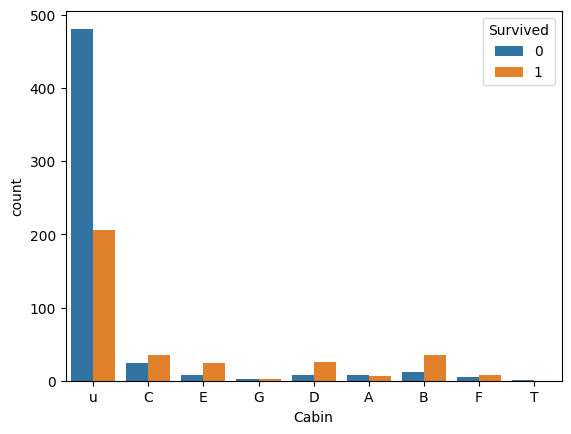

In [29]:
train_original["Cabin"] =train_original["Cabin"].fillna("unknown")
train_original["Cabin"] = train_original["Cabin"].str[0]
sns.countplot(x="Cabin",hue="Survived",data=train_original)

分からない人は置いておいて、C,E,D,B,Fの人は生存率が高い

<Axes: xlabel='familysize', ylabel='count'>

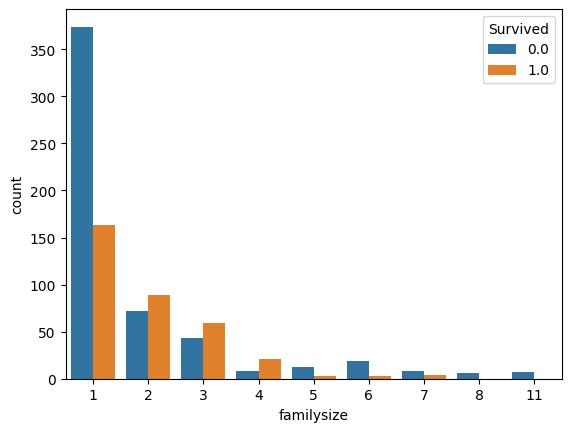

In [30]:
train["familysize"] = train["Parch"]+train["SibSp"]+1
sns.countplot(x="familysize",hue="Survived",data=train)

familysizeが5以上か、1の場合には死亡率が高い

<Axes: xlabel='Pclass', ylabel='count'>

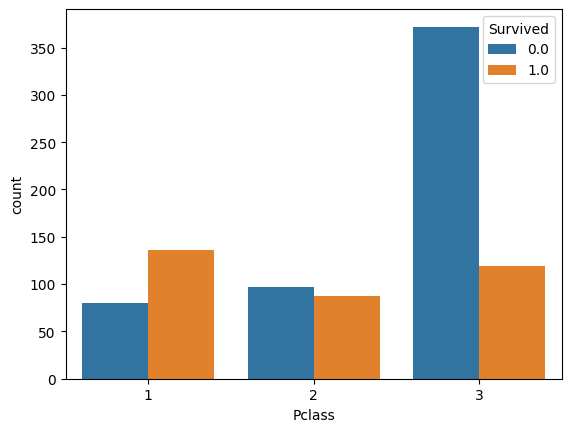

In [31]:
sns.countplot(x="Pclass",hue="Survived",data=train)

Pclassが大きくなればなるほど、死ぬ可能性が高くなる
Pclassはticket classであり、大きくなるほどランクが下がる

<Axes: xlabel='Sex', ylabel='count'>

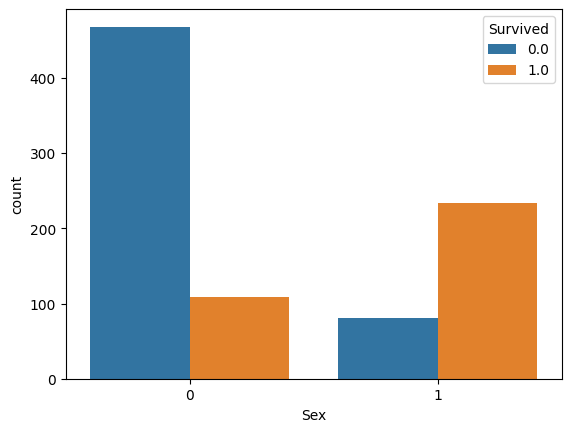

In [32]:
sns.countplot(x="Sex",hue="Survived",data=train)

つまり、女性のほうが生き残りやすい

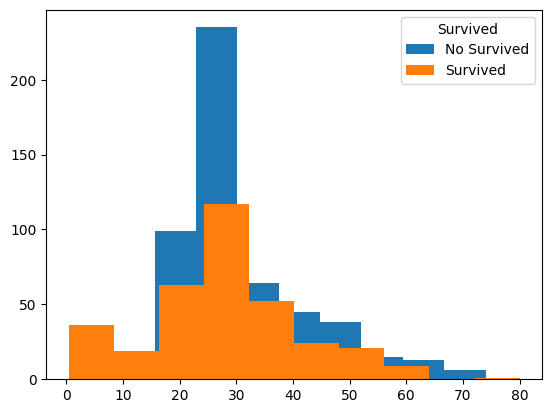

In [33]:
age_s = train[train["Survived"]==1]["Age"]
age_n = train[train["Survived"]==0]["Age"]

plt.hist(age_n,label="No Survived")
plt.hist(age_s,label="Survived")
plt.legend(title="Survived")

つまり、若い人のほうが生き残りやすい。特に40代以降は死ぬ人が多い

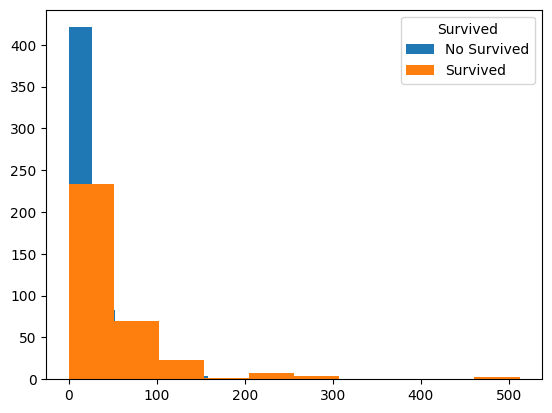

In [34]:
age_s = train[train["Survived"]==1]["Fare"]
age_n = train[train["Survived"]==0]["Fare"]

plt.hist(age_n,label="No Survived")
plt.hist(age_s,label="Survived")
plt.legend(title="Survived")

つまり、多くお金を払っている人のほうが生き残りやすい

In [35]:
fare1= train[train["Pclass"]==1]["Fare"]
print("fare1",fare1.max(),fare1.min())

fare2= train[train["Pclass"]==2]["Fare"]
print("fare2",fare2.max(),fare2.min())

fare3= train[train["Pclass"]==3]["Fare"]
print("fare3",fare3.max(),fare3.min())

train[train["Fare"]==0]

fare1 512.3292 0.0
fare2 73.5 0.0
fare3 69.55 0.0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked_C,...,TicketGroup,unknown-woman,unknown-man,unknown-high,unknown-middle,unknown-low,unknown-group0,unknown-group1,unknown-group2,Surname_Count
179,180,0.0,3,"Leonard, Mr. Lionel",0,36.0,0,0,0.0,0,...,2,1,1,1,0,0,1,1,1,1
263,264,0.0,1,"Harrison, Mr. William",0,40.0,0,0,0.0,0,...,1,1,1,0,0,0,1,1,1,1
271,272,1.0,3,"Tornquist, Mr. William Henry",0,25.0,0,0,0.0,0,...,2,1,1,1,0,0,1,1,1,1
277,278,0.0,2,"Parkes, Mr. Francis ""Frank""",0,28.0,0,0,0.0,0,...,2,1,1,0,1,0,1,1,1,1
302,303,0.0,3,"Johnson, Mr. William Cahoone Jr",0,19.0,0,0,0.0,0,...,2,1,1,1,0,0,1,1,1,6
413,414,0.0,2,"Cunningham, Mr. Alfred Fleming",0,28.0,0,0,0.0,0,...,2,1,1,0,1,0,1,1,1,1
466,467,0.0,2,"Campbell, Mr. William",0,28.0,0,0,0.0,0,...,2,1,1,0,1,0,1,1,1,1
481,482,0.0,2,"Frost, Mr. Anthony Wood ""Archie""",0,28.0,0,0,0.0,0,...,1,1,1,0,1,0,1,1,1,1
597,598,0.0,3,"Johnson, Mr. Alfred",0,49.0,0,0,0.0,0,...,2,1,1,1,0,0,1,1,1,6
633,634,0.0,1,"Parr, Mr. William Henry Marsh",0,28.0,0,0,0.0,0,...,1,1,1,0,0,1,1,1,1,1


fareに関しては載っているのに「0」となっている人がいるため、逆に気にしすぎるとよくないかも

<Axes: xlabel='Embarked', ylabel='count'>

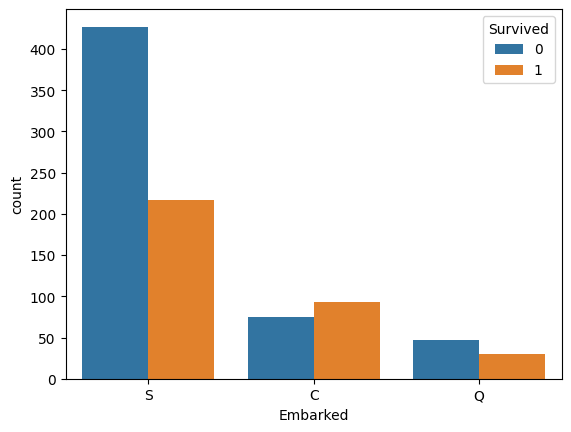

In [36]:
sns.countplot(x=train_original["Embarked"],hue=train_original["Survived"],data=train_original)

出発地点が0の場合、つまりサウサンプトンの場合は死亡率が高い<br>
["S","C","Q"]→[0,1,2]

<Axes: xlabel='SibSp', ylabel='count'>

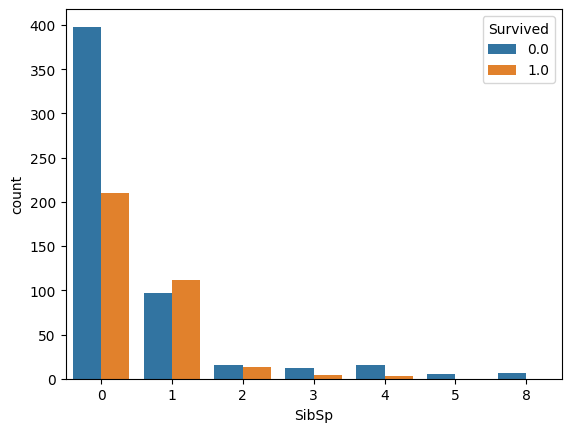

In [37]:
sns.countplot(x="SibSp",hue="Survived",data=train)

sibspとは配偶者か兄弟という意味。つまり配偶者がいない場合には、死亡率が高い。
逆に他1名と載っている場合には生存率が高い

<Axes: xlabel='Parch', ylabel='count'>

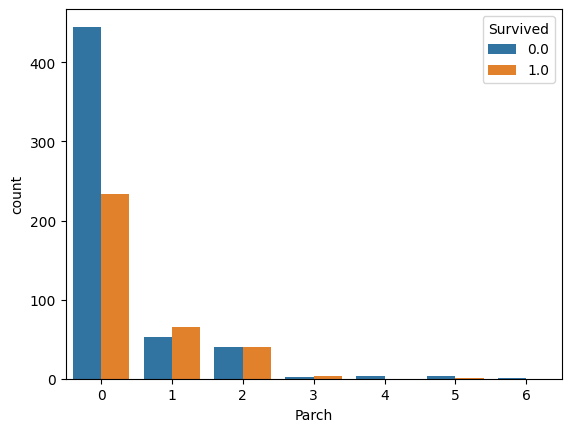

In [38]:
sns.countplot(x="Parch",hue="Survived",data=train)

parchとは子供の数。子供の数が0人だったら死亡率が高い。逆に1人の場合と3人の場合は高い

In [39]:
train = train_original

ticket_last =[]
for ticket_name in train_original["Ticket"]:
    ticket_last.append(ticket_name[0])
train["ticket_last"] = ticket_last

<Axes: xlabel='ticket_last', ylabel='count'>

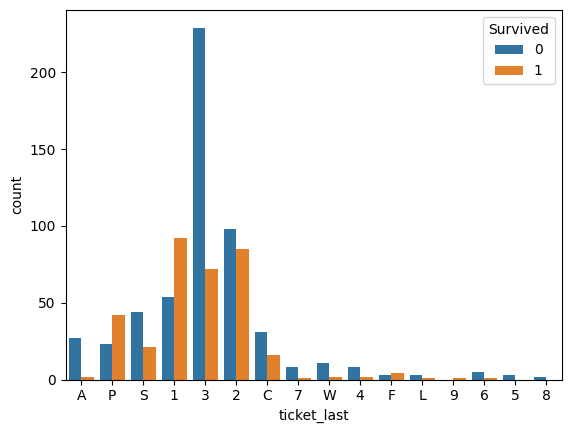

In [40]:
sns.countplot(x=train["ticket_last"],hue="Survived",data=train)

もしかしたら、P、1、Fが最初に貼っている場合には、Survivedになりやすいかも。